### Imports

In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import minimize
from tqdm import tqdm

from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.passes import LightCone, RemoveBarriers
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit_aer.noise import NoiseModel

sys.path.append("..")
from scripts.utils.kp_utils import generate_inversely_strongly_correlated, convert_bitstring_to_values, compute_approximate_ratio, convert_bitstring_to_values
from qkp_solver import QKPOptimizer
from scripts.utils.visualize import plot_multiple_distributions
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver

### Connect to backend

In [2]:
service = QiskitRuntimeService(name='enablement-work')
backend = service.backend('ibm_torino')
print("Backend Connected.")

Backend Connected.


In [3]:
from qiskit.transpiler import generate_preset_pass_manager

n = 104 # number of qubits
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)#, initial_layout=list(range(n)))
shots = 10_000 # number of shots
p = 1 # number of layers for the QAOA circuit
load_factor = 0.8  # if set to None; random load between [0.25-0.75] max weight
light_cone = True
full_circuit_optimization = False
func_distribution = generate_inversely_strongly_correlated
transpilation_level = 3

k_range = 5  # Simplified from np.arange(10, 24, 1)
theta_range = [-1]  # Simplified from [0, -0.5, -1]
bit_mapping = 'regular' # choose 'inverse' to solve UC

# Generate values and weights for the current distributioné
v, w = func_distribution(n)
v = v/np.max(v)
c = np.ceil(load_factor * sum(w)).astype(int)

### Define cost function, not sure if this is consistent with the cost unitary in the qaoa ansatz.

In [4]:
def cost_hamiltonian_paulis_op(n, v):
    """ Construct the cost Hamiltonian as a SparsePauliOp."""
    # Construct the cost Hamiltonian: H_C = sum_i (v_i / 2) * (I - Z_i)
    pauli_terms = []
    coeffs = []

    for i in range(n):
        # Z_i term
        z_string = ['I'] * n
        z_string[i] = 'Y'
        pauli_terms.append(''.join(z_string))
        coeffs.append(-v[i]/2)  # coefficient for -Z_i

    # # Add the identity part: sum_i v_i / 2
    pauli_terms.append('I' * n)
    coeffs.append(sum(v)/2)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

cost_hamiltonian = cost_hamiltonian_paulis_op(n, v)

# Create QAOA ansatz using this cost Hamiltonian
gamma =  ParameterVector('γ', p)
beta = ParameterVector('β', p)
optimizer_C = QKPOptimizer(v, w, c,
                            mixer='copula_2',
                            generate_jobs=True,
                            run_hardware=True,
                            backend=None,
                            pass_manager=None,
                            p=p,)

p_dist = optimizer_C.logistic_bias(k=5)
initial_state_qc = optimizer_C.initial_state_preparation(QuantumCircuit(n), p_dist)


p_dist_test = np.zeros(104) # only here to ensure identity qaoa circ

cost_qc = QuantumCircuit(n)
mixer_qc = QuantumCircuit(n)

cost_layer = optimizer_C.generate_cost_unitary(gamma=gamma[0])
mixer_layer = optimizer_C.ring_copula_mixer(QuantumCircuit(n), p_dist,theta=-1, beta=beta[0])
cost_qc.compose(cost_layer, inplace=True)
mixer_qc.compose(mixer_layer, inplace=True)

# Construct the QAOA ansatz with both gamma and beta vector elements
qaoa_ansatz = QAOAAnsatz(cost_operator=cost_layer,
                         initial_state=initial_state_qc,
                         mixer_operator=mixer_qc,
                         reps=p)

# Remove barriers from the circuit (necessary for light cone transpilation)
qaoa_ansatz = RemoveBarriers()(qaoa_ansatz.decompose())
print(f"Logical circuit depth: {qaoa_ansatz.decompose().depth(lambda x: len(x.qubits)==2)}")


Logical circuit depth: 16


In [5]:
nm = None
coupling_map = backend.configuration().coupling_map
basis_gates = backend.basis_gates

# initialize noisy simulator
estimator_mps = EstimatorV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                               })

sampler_mps = SamplerV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                                 })

print("Transpiling the circuit...")
transpiled_circuit = pm.run(qaoa_ansatz)

print(f"(Transpiled) Circuit depth: {transpiled_circuit.depth()}")
print(f"(Transpiled) 2Q gates depth: {transpiled_circuit.depth(lambda x: (len(x.qubits)==2))}")
print(f"(Transpiled) Total 2Q gates: {transpiled_circuit.num_nonlocal_gates()}")

Transpiling the circuit...
(Transpiled) Circuit depth: 51
(Transpiled) 2Q gates depth: 8
(Transpiled) Total 2Q gates: 416


In [6]:
objective_func_vals_lc = []
params = list(qaoa_ansatz.parameters)

def compute_light_cone_circuits(ansatz, hamiltonian):
    """
    Compute the light cone reduced circuits for each Pauli term in the Hamiltonian.
    For identity terms (no active qubits), None is stored.
    Returns a list of reduced circuits.
    """
    light_cone_list = []
    reduced_paulis = []
    num_qubits = len(hamiltonian.paulis[0])

    pbar = tqdm(total=len(hamiltonian.paulis), desc="Light cone computation")
    for i, pauli_term in enumerate(hamiltonian.paulis):

        pauli_str = pauli_term.to_label()
        active_indices = [(num_qubits-1-i) for i, p in enumerate(pauli_str) if p != "I"]

        if not active_indices:
            light_cone_list.append(None)
            reduced_paulis.append(None)
            pbar.update(1)
            continue

        t0 = time.perf_counter() # timer for the progress bar
        lc_pass = LightCone(bit_terms="Z", indices=active_indices)
        reduced_dag = lc_pass.run(circuit_to_dag(ansatz))
        reduced_circuit = dag_to_circuit(reduced_dag)
        elapsed = time.perf_counter() - t0

        light_cone_list.append(reduced_circuit)
        reduced_paulis.append(pauli_term)

        pbar.set_postfix(last_time=f"{elapsed:.6f} s")
        pbar.update(1)
    pbar.close()

    return light_cone_list, reduced_paulis


def cost_func_lightcone(params_values, ansatz, hamiltonian, estimator, light_cone_data):
    """Compute total expectation using precomputed light-cone-reduced circuits with EstimatorV2."""

    light_cone_list, reduced_paulis = light_cone_data
    total = 0.0
    param_dict = dict(zip(ansatz.parameters, params_values))

    for i, pauli_term in enumerate(hamiltonian.paulis):
        coeff = hamiltonian.coeffs[i].real
        pauli_str = pauli_term.to_label()

        if light_cone_list[i] is None:
            # Handle identity term
            total += coeff
            continue

        reduced_circuit = light_cone_list[i]
        reduced_params = [param_dict[p] for p in reduced_circuit.parameters if p in param_dict]
        # reduced_pauli = SparsePauliOp(pauli_str)

        # Run estimator with the correct Pauli operator
        job = estimator.run([(reduced_circuit, reduced_paulis[i], reduced_params)])
        result = job.result()[0]
        ev = result.data.evs
        total += coeff * ev

    objective_func_vals_lc.append(total)
    return -total

### Loop to find optimal parameters, not needed for the trivial qaoa case

Light cone computation: 100%|██████████| 105/105 [00:00<00:00, 139.85it/s, last_time=0.006268 s]


Iteration 9: Current params = [0.13118419 0.31133311]
Iteration 12: Current params = [0.12818844 0.26980708]
Iteration 15: Current params = [0.06376767 0.09249691]
Iteration 18: Current params = [0. 0.]
Iteration 9: Current params = [0.25810952 0.65146305]
Iteration 12: Current params = [0.25717026 0.52575935]
Iteration 15: Current params = [0.16369193 0.2456554 ]
Iteration 18: Current params = [0.05840884 0.12274542]
Iteration 21: Current params = [0.         0.01311063]
Iteration 24: Current params = [0. 0.]
Iteration 6: Current params = [0.97854311 0.55627853]
Iteration 9: Current params = [1.01581117 0.        ]
Iteration 12: Current params = [1.49149735 0.        ]
Iteration 18: Current params = [1.55153699 0.        ]
Iteration 21: Current params = [1.55404122 0.        ]
Iteration 6: Current params = [0.7676114  1.11104317]
Iteration 9: Current params = [0.58700514 0.81193144]
Iteration 12: Current params = [0.         0.02462022]
Iteration 15: Current params = [0. 0.]
Iteration

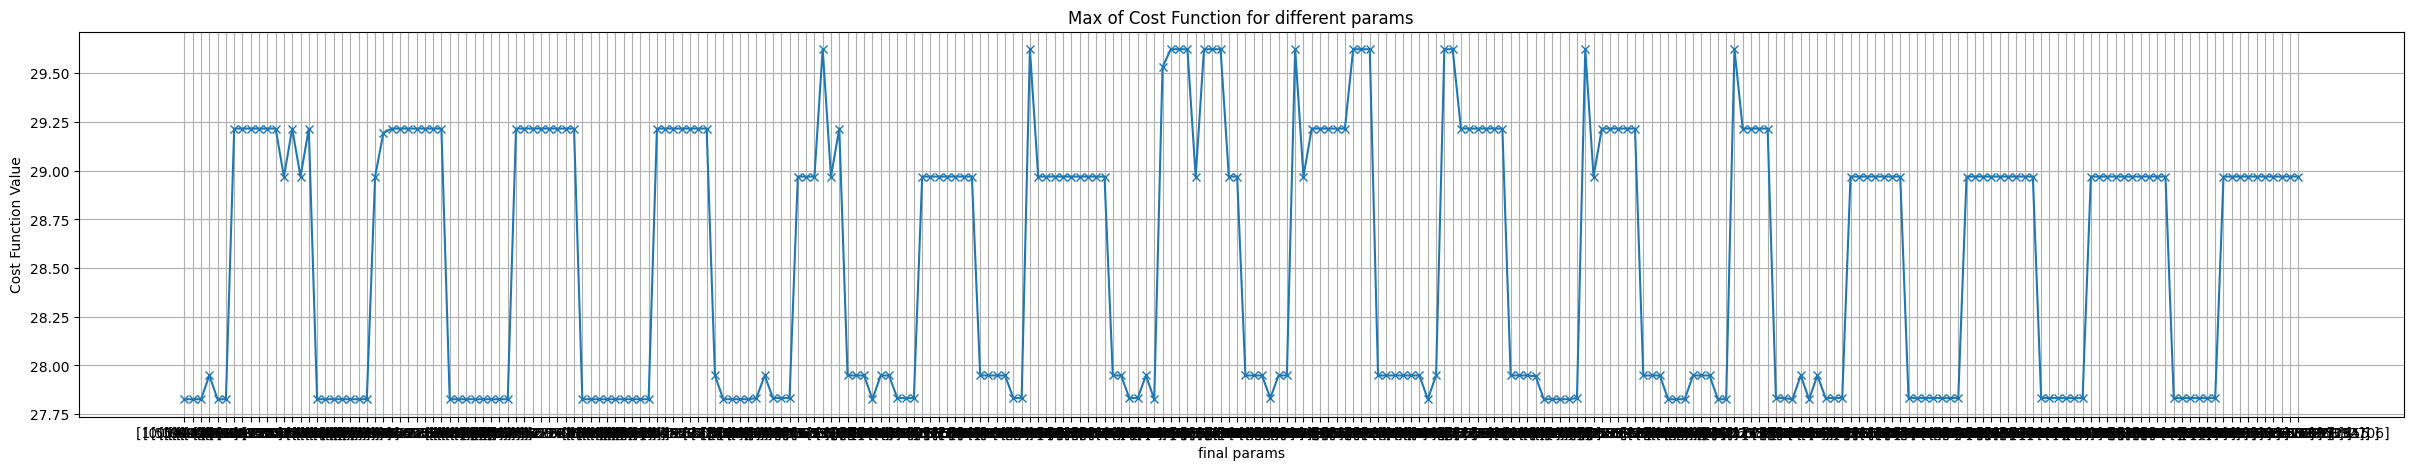

In [7]:
list_reduced_circuit = []
params = list(qaoa_ansatz.parameters)

mapped_H_for_lc = cost_hamiltonian.apply_layout(transpiled_circuit.layout)
lc_data = compute_light_cone_circuits(transpiled_circuit, mapped_H_for_lc) # Pass the same circuit

plt.figure(figsize=(30, 5))
x_vals= []
y_vals = []
max_iter = 16
for i in range(max_iter):
    for j in range(max_iter):
        objective_func_vals_lc= [] 
        init_params = [i*np.pi/(max_iter-1), 2*j*np.pi/(max_iter-1)] * p
        # Optimize
        result_lc = minimize(
        cost_func_lightcone,
        init_params,
        args=(transpiled_circuit, mapped_H_for_lc, estimator_mps, lc_data),
        #method="COBYQA",
        bounds=[(0, np.pi), (0, 2*np.pi)] * p,
        tol=1e-6,
        options={"maxiter":100, "disp":True},
        callback=lambda xk: print(f"Iteration {len(objective_func_vals_lc)}: Current params = {xk}"),
        )
        y_vals.append(max(objective_func_vals_lc))
        x_vals.append((result_lc.x))

    
    
x_positions = list(range(len(x_vals)))  # numeric x positions
x_labels_str = [str(t) for t in x_vals] 
plt.xticks(x_positions, x_labels_str)
plt.plot(y_vals,marker='x')
plt.xlabel("final params")
plt.ylabel("Cost Function Value")
plt.title("Max of Cost Function for different params")
plt.grid(True)
plt.show()

In [12]:
#pick out best final param

[i for i in range(len(x_vals)) if y_vals[i] == np.max(y_vals)]

[123]

In [13]:
x_vals[123]

array([1.66469263, 6.28318531])

Optimization Results Gurobi -- 104 items
Bitstring: 00101111111110010111000111011101110100010100101110101011011111110011101100101010011010000111010110101011


Processing bitstrings: 100%|██████████| 10000/10000 [00:00<00:00, 46051.27it/s]


Best value: 41.08708708708709

Greedy Warm Start Solution


Processing bitstrings: 100%|██████████| 10000/10000 [00:00<00:00, 62461.71it/s]



Random Distribution Solution


Processing bitstrings: 100%|██████████| 10000/10000 [00:00<00:00, 45580.30it/s]


Best value: 35.862862862862855


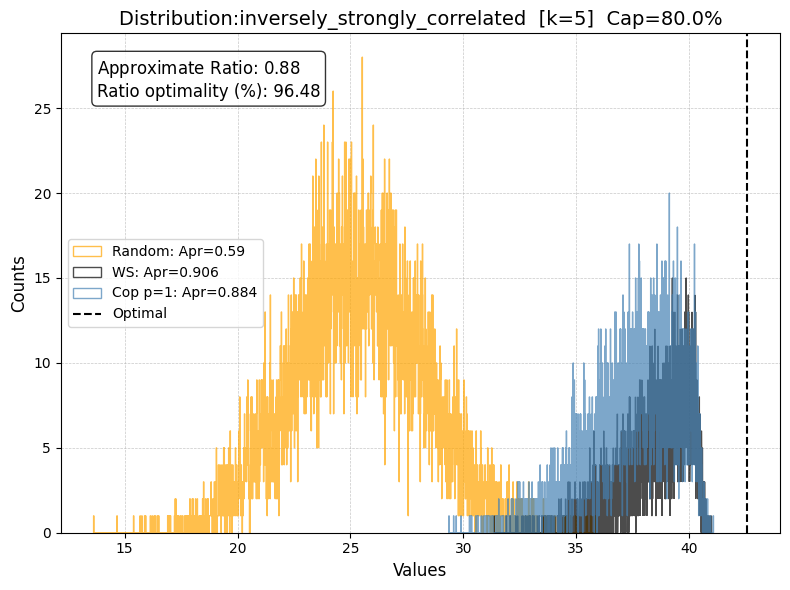

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution:inversely_strongly_correlated  [k=5]  Cap=80.0%'}, xlabel='Values', ylabel='Counts'>)

In [19]:
from scripts.utils.kp_utils import probabilty_success

est = False

if light_cone:
    opt_circuit_lc = transpiled_circuit.assign_parameters([1.66469263, 6.28318531])

    if est:
        job_lc = estimator_mps.run([(opt_circuit_lc, mapped_H_for_lc)])
    else:
    # add measurement
        opt_circuit_lc.measure_active()
        job_lc = sampler_mps.run([(opt_circuit_lc,)], shots=shots)
    
        counts_int_lc = job_lc.result()[0].data.meas.get_int_counts()
        counts_bin_lc = job_lc.result()[0].data.meas.get_counts()

        counts_bin_lc_rev = {}
        for key in counts_bin_lc.keys():
            reversed_key = key[::-1]
            counts_bin_lc_rev[reversed_key] = counts_bin_lc[key]
    

if full_circuit_optimization:
    opt_circuit_reg = transpiled_circuit.assign_parameters(result_reg.x)
    opt_circuit_reg.measure_active()  # add measurement
    job_reg = sampler_mps.run([(opt_circuit_reg,)], shots=shots)
    counts_int_reg = job_reg.result()[0].data.meas.get_int_counts()
    counts_bin_reg = job_reg.result()[0].data.meas.get_counts()


#Gurobi Solver Knapsack
result_gurobi = gurobi_knapsack_solver(v, w, c, verbose=False,
                                       time_limit=60,
                                       optimality_gap=1e-20,
                                       feasibility_tolerance=1e-9)
value_opt = result_gurobi['total_value']
print(f"Optimization Results Gurobi -- {n} items")
print(f"Bitstring: {result_gurobi['bitstring']}")


filter_sols = True
if not est:
    if light_cone:
        dict_bit_values_lc_rev = convert_bitstring_to_values(counts_bin_lc_rev, v, w, c,
                                            filter_invalid_solutions=filter_sols)

    #Sort the dictionary by value
    sorted_dict = dict(sorted(dict_bit_values_lc_rev.items(), key=lambda item: item[0], reverse=True))
    best_value = max(sorted_dict.keys())
    best_count = sorted_dict[best_value]
    print(f"Best value: {best_value}")

    aprox_ratio = compute_approximate_ratio(dict_bit_values_lc_rev, value_opt)


print("\nGreedy Warm Start Solution")

# def logistic_bias(v, w, c, k):
#     """Creates a biased initial distribution using the logistic function."""
#     r = np.array(v) / np.array(w)
#     C = (sum(w) / c) - 1
#     return 1 / (1 + C * np.exp(-k * (r - r.mean())))

# Calculate probabilities using logistic_bias
r = v/w # Calculate r_i = v_i/w_i ratios

warm_start_counts = defaultdict(int)

for _ in range(shots):
    bitstring = ''.join(str(int(np.random.random() < pi)) for pi in p_dist)
    warm_start_counts[bitstring] += 1

# Convert to value distribution
dict_bit_values_ws = convert_bitstring_to_values(warm_start_counts, v, w, c,
                                                   filter_invalid_solutions=filter_sols)

# Compute the probability of sucess
p_sucess_ws= probabilty_success(dict_bit_values_ws, value_opt)
aprox_ratio_ws = compute_approximate_ratio(dict_bit_values_ws, value_opt)

print("\nRandom Distribution Solution")

random_counts = defaultdict(int) # generate dict with default value of 0
for _ in range(shots):
    bitstring = ''.join(str(x) for x in np.random.randint(2, size=n))
    random_counts[bitstring] += 1

dict_bit_values_random = convert_bitstring_to_values(random_counts, v, w, c,
                                                     filter_invalid_solutions=filter_sols)

# Compute the probability of sucess
aprox_ratio_random = compute_approximate_ratio(dict_bit_values_random, value_opt)
print(f"Best value: {max(dict_bit_values_random.keys())}")

data_dict = {
f"Random: Apr={aprox_ratio_random:.2f}": dict_bit_values_random,
   f"WS: Apr={aprox_ratio_ws:.3f}": dict_bit_values_ws,
   f"Cop p=1: Apr={aprox_ratio:.3f}": dict_bit_values_lc_rev,
}
# Custom colors
colors = {
    f"Random: Apr={aprox_ratio_random:.2f}": "orange",
    f"WS: Apr={aprox_ratio_ws:.3f}": 'black',
    f"Cop p=1: Apr={aprox_ratio:.3f}": "steelblue",
}    
# Annotations
annotations = {
   r"$\mathrm{Approximate\ Ratio}$": np.round(aprox_ratio, 2),
   "Ratio optimality (%)": np.round(best_value /value_opt *100, 2),
}
plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=value_opt,
    colors=colors,
    nb_bins=2000,
    log=False,
    annotations=annotations,
    figsize=(8, 6),
    title=f"Distribution:{func_distribution.__name__[9:]}  [k={k_range}]  Cap={load_factor*100}%"
)


#### Compare the best warm start value with the best qaoa value

In [20]:
print(f"QAOA best value :{max(dict_bit_values_lc_rev.keys())}")

print(f"WS Best value: {max(dict_bit_values_ws.keys())}")

QAOA best value :41.08708708708709
WS Best value: 41.00100100100101
